In [1]:
#SEED ALL for reproducibility
from numpy.random import seed
import tensorflow as tf

cherrypicked_seed = 1

seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)


### AutoEncoders  

An autoencoder is an artificial neural network used for learning efficient representations of the input.

The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.

<img src="https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" width="65%">

### Reference

Based on [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

---

## Dataset

In [2]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.datasets import fashion_mnist

import numpy as np

In [3]:
(X_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
X_train.shape

(60000, 784)

## Model Design

### The main AE model

In [5]:
# this is the size of our encoded representations
encoding_dim = 32
activation = "relu"

# this is our input placeholder
input = Input(shape=(784,)) #28 x28

# hiddent layers
downsampling_hidden_1 = Dense(256, activation = activation, name = "downsampling_hidden_1")(input)

downsampling_hidden_2 = Dense(64, activation = activation, name = "downsampling_hidden_2")(downsampling_hidden_1)

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation=activation, name = "latent")(downsampling_hidden_2)

upsampling_hidden_1 = Dense(64, activation = activation, name = "upsampling_hidden_1")(encoded)

upsampling_hidden_2 = Dense(256, activation = activation, name = "upsampling_hidden_2")(upsampling_hidden_1)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid', name = "decoder")(upsampling_hidden_2)

# this model maps an input to its reconstruction
autoencoder = Model(input, decoded)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_1 (Dense)   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_2 (Dense)   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_1 (Dense)     │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_2 (Dense)     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 439,728 (1.68 MB)

 Trainable params: 439,728 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

### SubModels

The functional api allows to create **submodels**.

Here we will instanciate two submodels, one responisble for the encoding  section of the AE (**encoder**), and the other for the decoding section (**decoder**).

In [6]:
# this model maps an input to its encoded representation
encoder_model = Model(input, encoded)
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_1 (Dense)   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_2 (Dense)   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,488 (857.38 KB)

 Trainable params: 219,488 (857.38 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
## SUBMODEL FOR THE DECODER

# create the decoder model
decoder_model = Model(encoded, decoded)

decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_3CLONE             │ (None, 32)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_1 (Dense)     │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_2 (Dense)     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,240 (860.31 KB)

 Trainable params: 220,240 (860.31 KB)

 Non-trainable params: 0 (0.00 B)

## Training and Evaluation

In [8]:
#otherwise linear activation in the output and mse loss would work as well

autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics = ["mse"])
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_1 (Dense)   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_2 (Dense)   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_1 (Dense)     │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_2 (Dense)     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 439,728 (1.68 MB)

 Trainable params: 439,728 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#note: X_train, X_train :)
#also note: "encoder_model" and "decoder_model" are just "pointers" to the autoencoder main model. This means that when the AE is trained, the encoder and the decoder will point to the trained weights.
network_history = autoencoder.fit(X_train,X_train,
                epochs=100,
                batch_size=1024,
                shuffle=True,
                validation_split=0.1)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5609 - mse: 0.1141 - val_loss: 0.3748 - val_mse: 0.0456
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3591 - mse: 0.0409 - val_loss: 0.3332 - val_mse: 0.0308
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3261 - mse: 0.0289 - val_loss: 0.3185 - val_mse: 0.0251
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3141 - mse: 0.0245 - val_loss: 0.3149 - val_mse: 0.0238
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3088 - mse: 0.0227 - val_loss: 0.3077 - val_mse: 0.0215
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3045 - mse: 0.0212 - val_loss: 0.3049 - val_mse: 0.0206
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3013 - mse: 0.0201 - val_loss: 0.3021 - val_mse: 0.0194
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3006 - mse: 0.0199 - val_loss: 0.3008 - val_mse: 0.0192
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

### Testing the Autoencoder

In [10]:
from matplotlib import pyplot as plt

%matplotlib inline

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


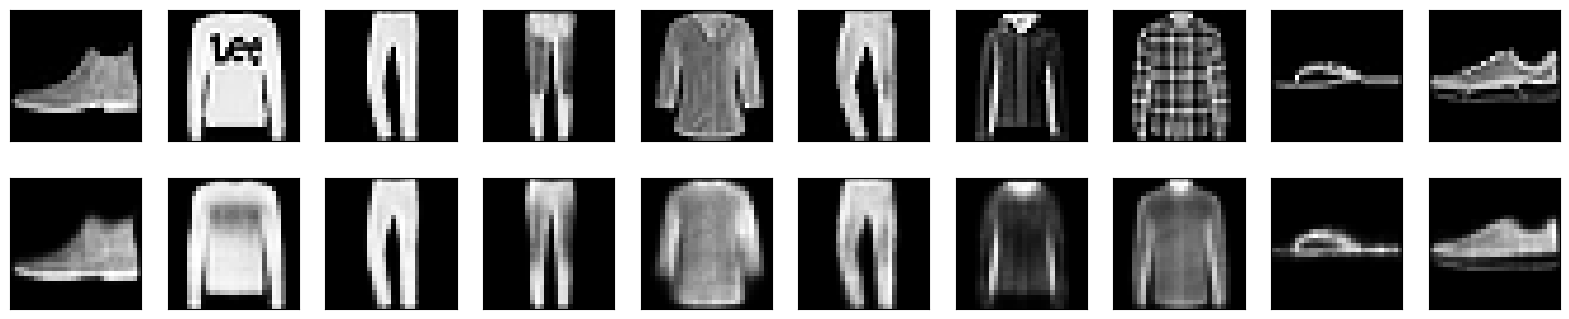

In [11]:
x_selected = x_test
encoded_imgs = encoder_model.predict(x_selected)
decoded_imgs = decoder_model.predict(encoded_imgs)

#autoencoder.predict(x_selected)
#alternative here?
#decoded_imgs = autoencoder.predict(x_selected)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_selected[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = autoencoder.predict(x_selected)

print(mean_absolute_error(x_test, pred))
print(mean_squared_error(x_test, pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.0523455
0.010460174


### Sample generation with Autoencoder

One of the powerful tools of auto-encoders is using the encoder to generate meaningful representation from the feature vectors.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


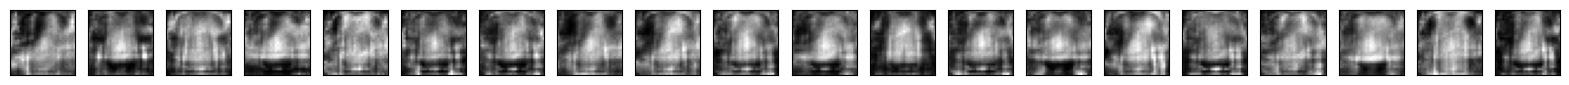

In [13]:
n = 20

random_encodings = np.random.rand(20,encoding_dim)
decoded_imgs = decoder_model.predict(random_encodings)

plt.figure(figsize=(20, 4))
for i in range(n):
    # generation
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Latent Representations


For some samples in `X_train`, we will **extract the latent features** (encodings) of the trained autoencoder model and compare these representations with classic dimensionality reduction techniques such as PCA and TSNE.

In [14]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [15]:
#we select four classes/labels for better visualization
selected_labels = [0,1,2]

train_selected_idxs = np.in1d(y_train, selected_labels)
val_selected_idxs = np.in1d(y_train, selected_labels)
X_train = X_train[train_selected_idxs]
y_train = y_train[train_selected_idxs]
X_train = X_train[:1000] #just for computational cost
y_train = y_train[:1000]

X_train.shape, y_train.shape, np.unique(y_train, return_counts = True)

((1000, 784),
 (1000,),
 (array([0, 1, 2], dtype=uint8), array([313, 362, 325], dtype=int64)))

#### TSNE and PCA

applied on `X_train`

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train) ## Reduced for computational issues


In [17]:
X_train_tsne.shape

(1000, 2)

In [18]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

### Extracting the AE encodings



In [19]:
AE_encodings = encoder_model.predict(X_train)
AE_encodings.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(1000, 32)

In [20]:
tsne = TSNE(n_components=2)
AE_encodings_tsne = tsne.fit_transform(AE_encodings)
pca = decomposition.PCA(n_components=2)
AE_encodings_pca = pca.fit_transform(AE_encodings)

### Visualize

In [21]:
#utility for plots
import plotly.express as px

def plot_data(X, y, title, is_3d = False):
  if not is_3d:
    fig = px.scatter(
        X, x=0, y=1, title=title,
        color=y, labels={'color': 'classes'})
    fig.update_traces(marker_size=6)

  else:
    fig = px.scatter_3d(
    X, x=0, y=1, z=2, title=title,
    color=y, labels={'color': 'classes'})
    fig.update_traces(marker_size=2)
  fig.show()

In [22]:
plot_data(X_train_tsne, y_train, title="TSNE", is_3d = False)
plot_data(X_train_pca, y_train, title="PCA", is_3d = False)
plot_data(AE_encodings[:, :2], y_train, title="Latent", is_3d = False)
plot_data(AE_encodings_tsne, y_train, title="TSNE + Latent", is_3d = False)
plot_data(AE_encodings_pca, y_train, title="PCA+Latent", is_3d = False)

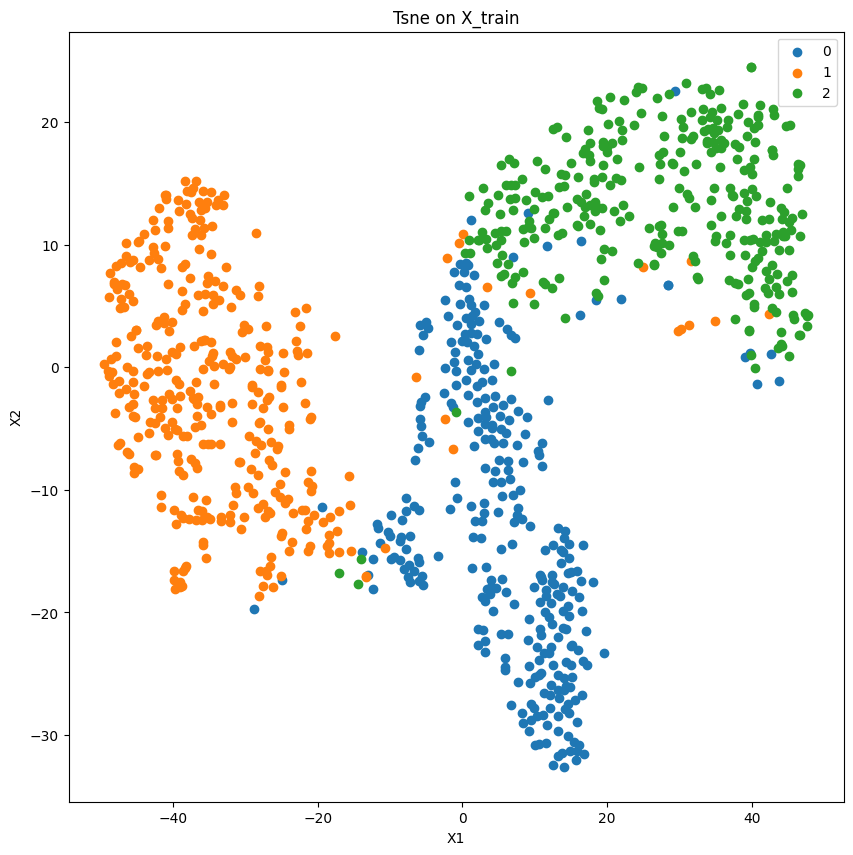

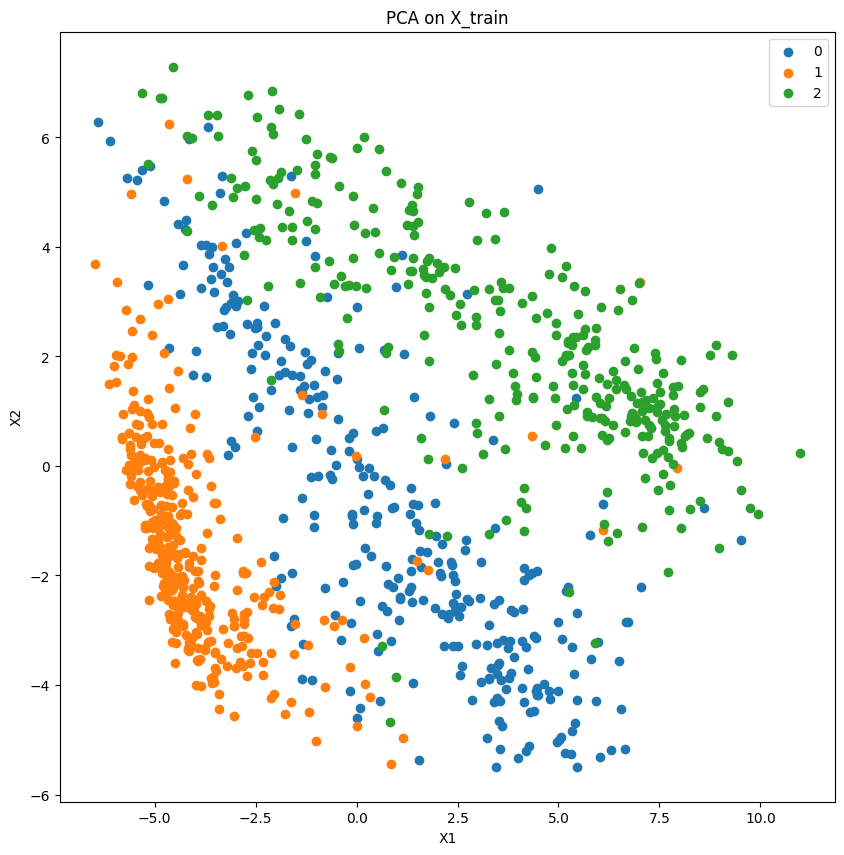

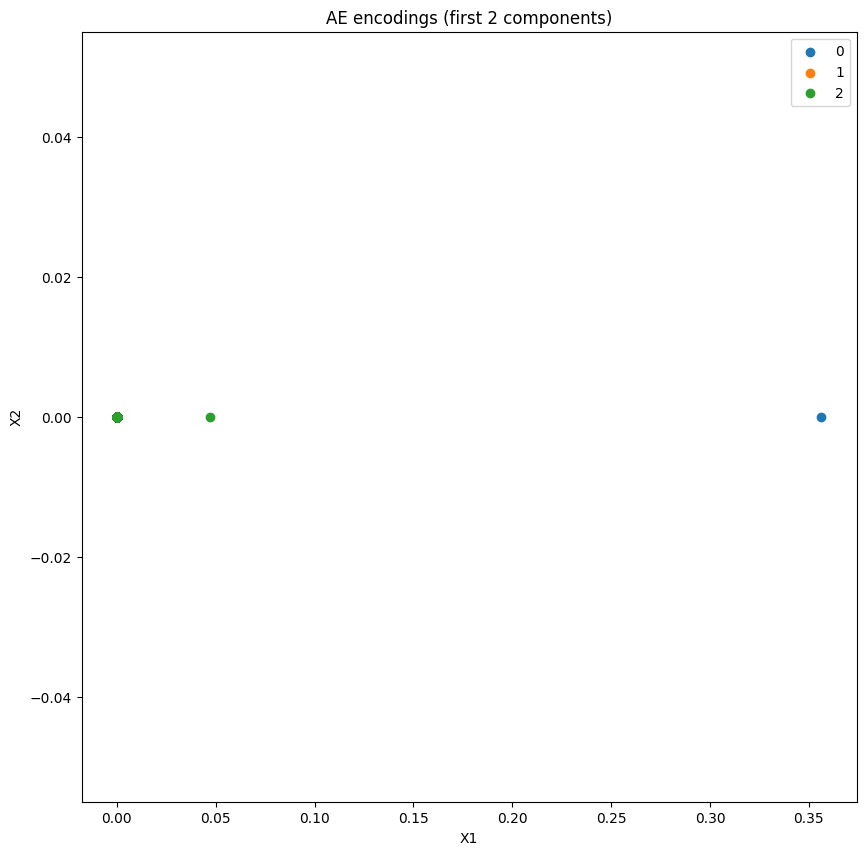

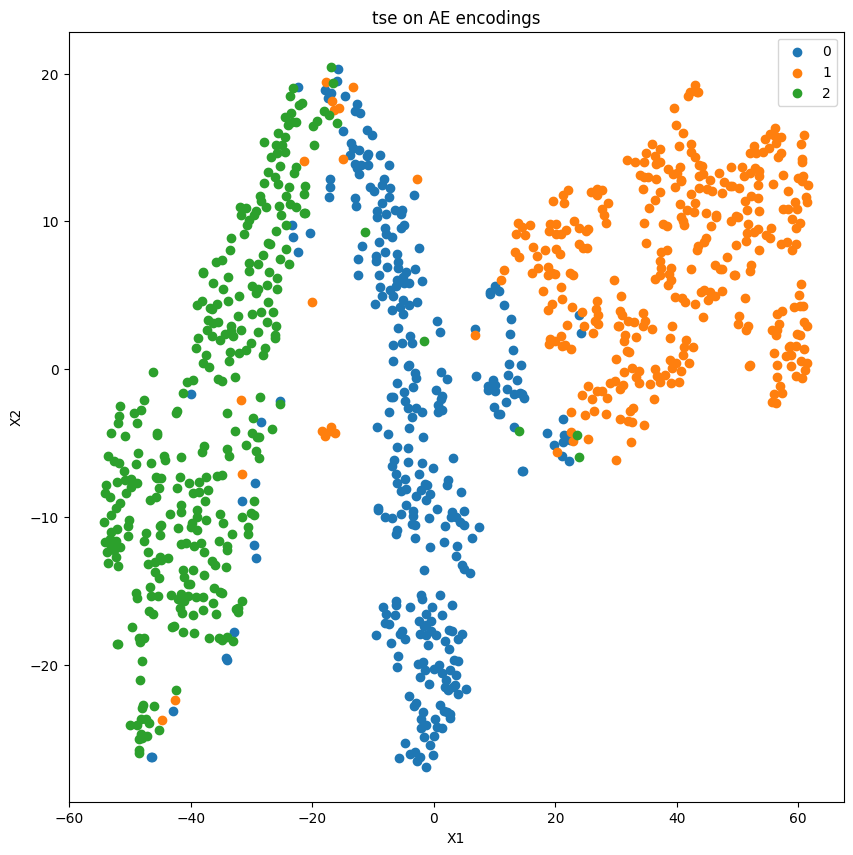

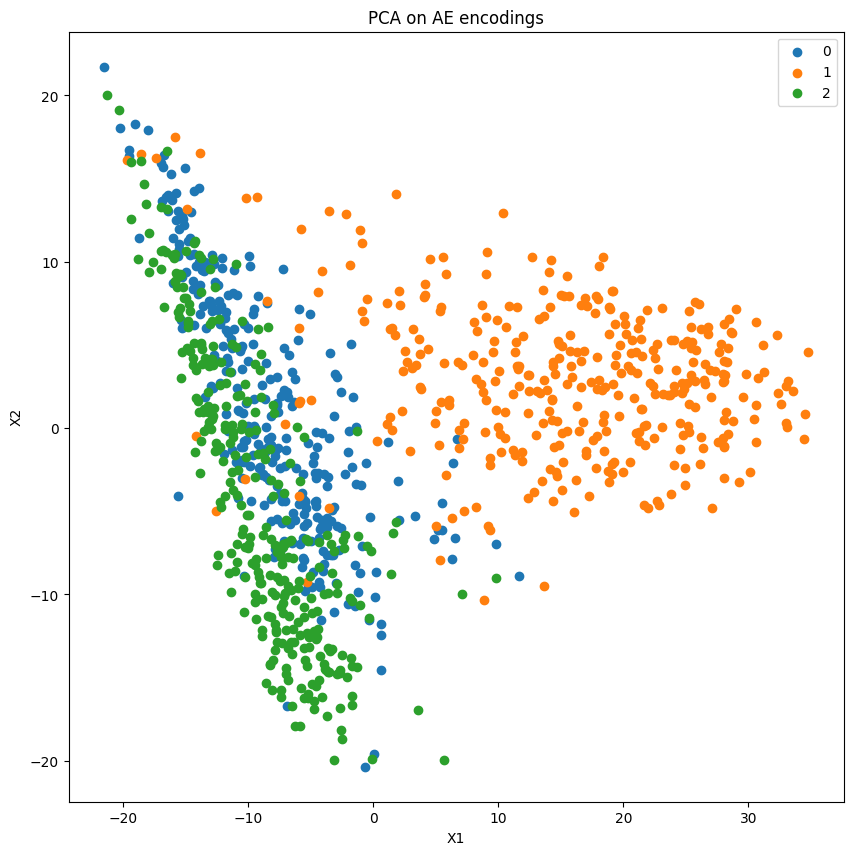

In [23]:
def plot_data(data, labels, title = "nonlinear data"):
    # Generate scatter plot for training data
    fig, ax = plt.subplots(figsize=(10,10))
    for g in np.unique(labels):
        i = np.where(labels == g)
        ax.scatter(data[i,0], data[i,1], label=g)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()

    plt.show()

plot_data(X_train_tsne, y_train, title = "Tsne on X_train")
plot_data(X_train_pca, y_train, title = "PCA on X_train")
plot_data(AE_encodings[:, :2], y_train, title = "AE encodings (first 2 components)")
plot_data(AE_encodings_tsne, y_train, title = "tse on AE encodings")
plot_data(AE_encodings_pca, y_train, title = "PCA on AE encodings")

## 📕 Exercise

Take a dataset from keras or kaggle (make sure you take a dataset with high dimensionality).
Build an autoencoder on this dataset.
Extract the latent representation and use it to classify the dataset with classical ML models. Compare the results of the "latent representation" with those of PCA or some other dimensionality reduction technique.